Deadline: 21.12.2022 2pm (14:00)

Tasks:


1.   Send an email with your Name and user-id to lukas.marx@uni-passau.de afterwards you will receive your personal dataset for this assignment.
2.   Import the three datasets (training, validation and test) into a google colab and analyze your given data set. Your target variable will be "discr_r".
3.   Generate a Linear Regression model as a benchmark and evaluate it (for comparison the mean absolute error as a performance metric is suggested). 
4.   Generate a neural network with an arbitrary choice of hyperparameters in order to perform a comparable task to the linear regression model and evaluate it. 
5.   Compare the feature importance for the benchmark and the baseline neural network.
6.   Perform hyperparameter tuning with Optuna in order to generate a better performing neural network. 
7.   Evaluate its results and compare them as well as the feature importance to the benchmark and the baseline neural network. 
8.   Describe your results for all three models and explain what your results means with respect to $(R_{Mt} - R_{ft})$ , SMB and HML.
9.   Hand in your single colab Notebook to lukas.marx@uni-passau.de until the above mentioned deadline. 



# 2. Import and first analysis of the Dataset 

In [12]:
!pip install --upgrade category_encoders


In [3]:
import seaborn as sns
import category_encoders as ce
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score

import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from scipy.stats import norm
import statsmodels.stats.api as sms
import statsmodels.api as sm
import tensorflow as tf

In [4]:
import pandas as pd
import numpy as np
from scipy.stats import mode

In [28]:
df_train =  pd.read_csv('train_data-8.csv')
df_train.head()

,Unnamed: 0,book_to_market,market_cap,beta,discr_r
0,2021-12-31,0.209056,4.860337e+09,0.678720,0.036031
1,2021-12-31,0.271499,6.261903e+07,2.186974,-0.299578
2,2021-12-31,0.670605,1.916217e+09,1.292221,0.003785
3,2021-12-31,0.716247,1.277952e+10,0.944942,0.031915
4,2021-12-31,0.114538,1.498425e+09,1.782655,0.154967


#### Elimination of the variable Unnamed:

In [29]:
df_train = df_train.drop(["Unnamed: 0"], axis = 1)

In [30]:
df_train.shape

(4963, 4)

#### Examine if missing values are present:

In [31]:
df_train['discr_r'].isnull().values.any()


False

In [32]:
df_train.isna().sum()

book_to_market    0
market_cap        0
beta              0
discr_r           0
dtype: int64

#### investigate datatypes:

In [33]:
df_train.dtypes

book_to_market    float64
market_cap        float64
beta              float64
discr_r           float64
dtype: object

 #### Mean, standard deviation, and number of surveys of our target value discr_r:

In [34]:
r_mean = df_train[["discr_r"]].mean()
r_mean

discr_r   -0.0011
dtype: float64

In [35]:
r_std = df_train[["discr_r"]].std()
r_std

discr_r    0.159674
dtype: float64

In [36]:
r_n = df_train[["discr_r"]].count()
r_n

discr_r    4963
dtype: int64

#### 95% Confidence Interval

In [37]:
conf = sms.DescrStatsW(df_train["discr_r"]).tconfint_mean(alpha=0.5)
conf

(-0.0026283941176417714, 0.0004293272981687013)

### Comments
no missing values in our target value and in the whole data-set!

## 2.2 Visualisation and Analysis

In [38]:
data = norm.rvs(-0.0011, 0.159674, size= 10000)
mu, std = norm.fit(data)

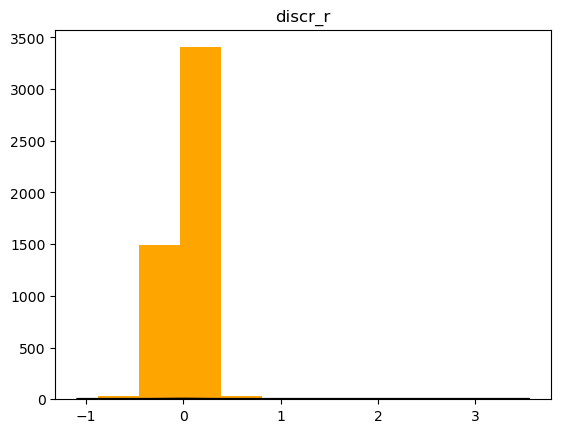

In [39]:
df_train.hist(column = "discr_r", color="orange", grid=False)

xmin, xmax = plt.xlim()
x = np.linspace(xmin, xmax, 100)
p = norm.pdf(x, mu, std)

plt.plot(x, p, "k", linewidth=2)

plt.show()

### outliers:

<AxesSubplot: >

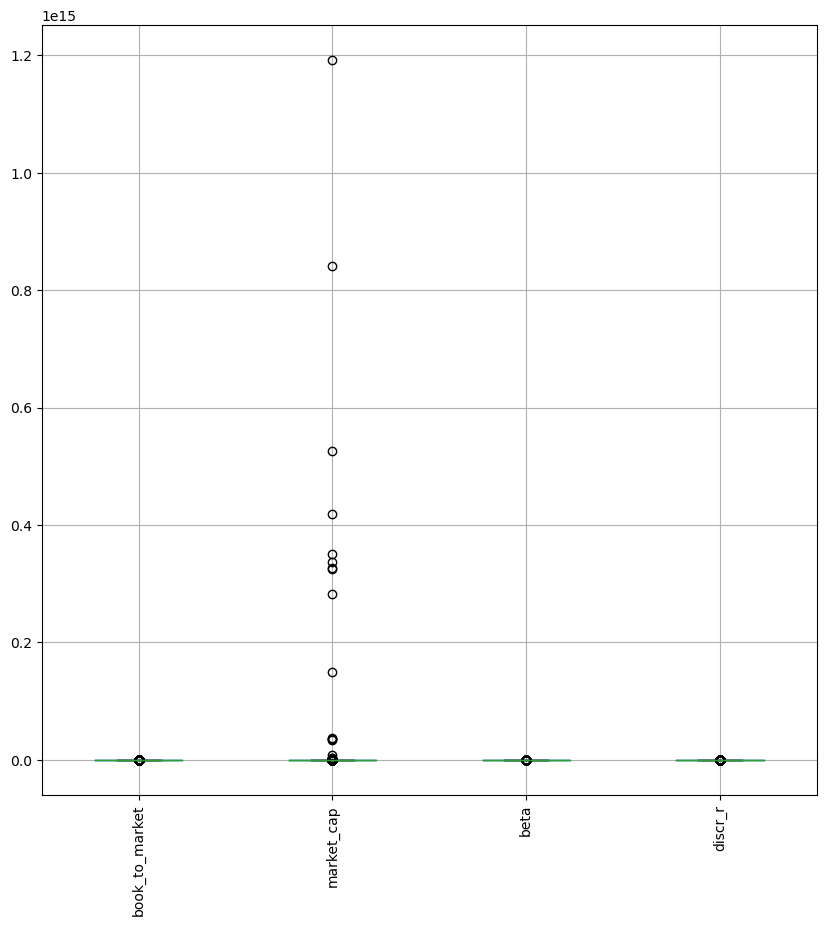

In [41]:
df_train.boxplot(figsize=(10,10), rot=(90))

market_cap with the most outliers

### checking for bivariate relationships:

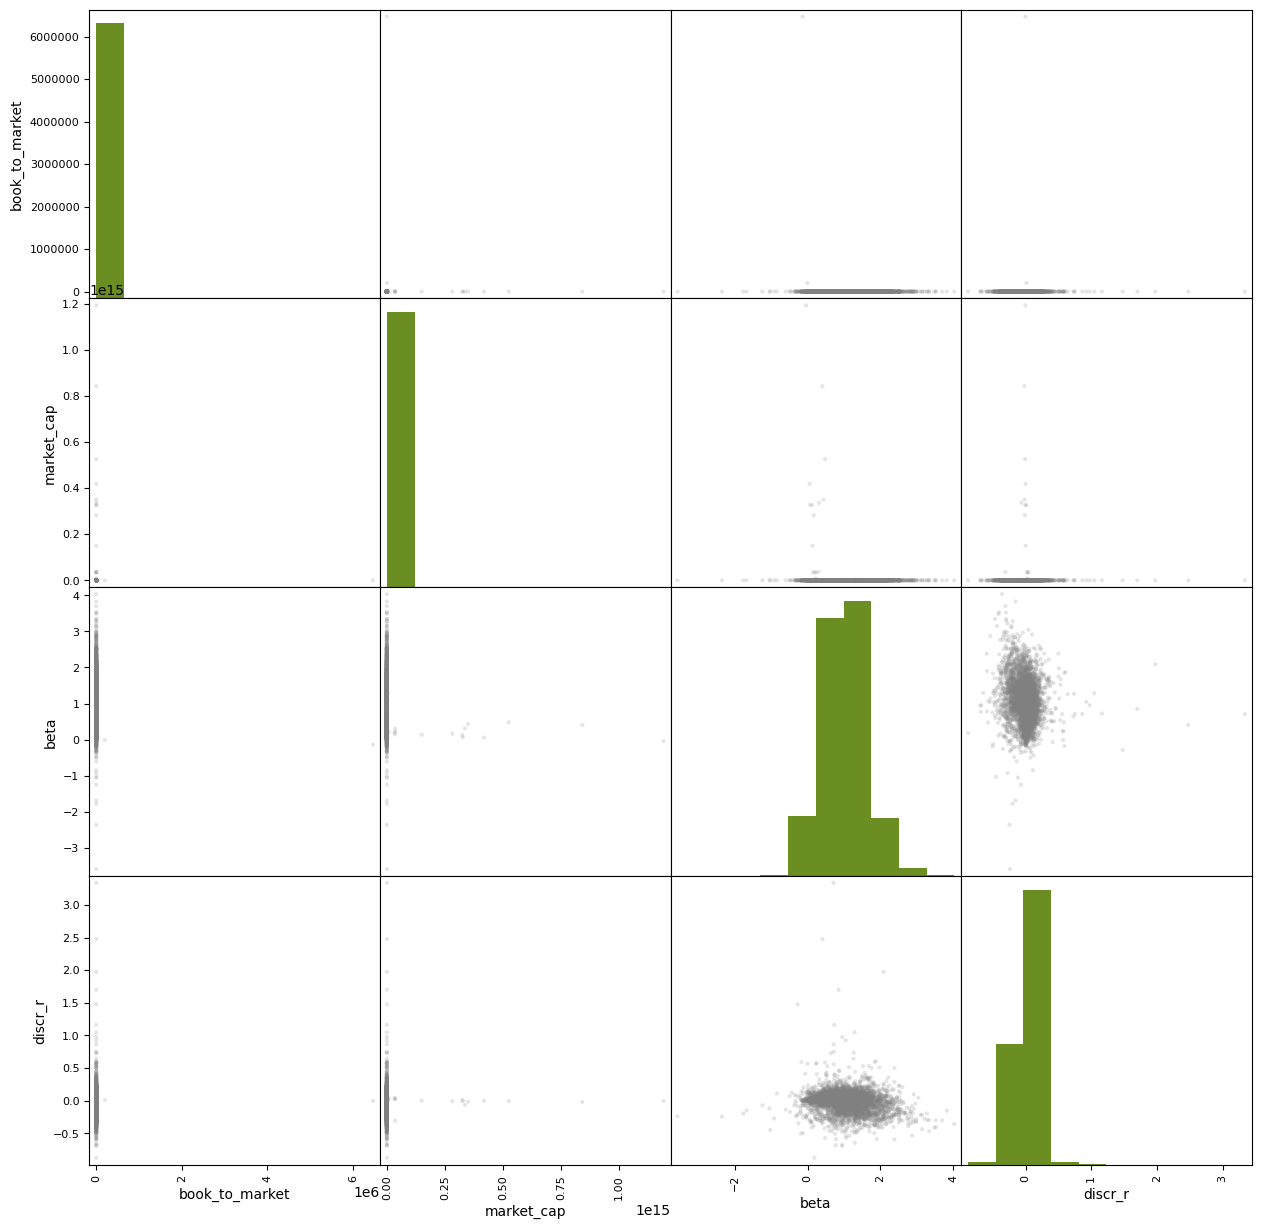

In [106]:
pd.plotting.scatter_matrix(df_train, alpha=0.2, figsize = (15,15), 
                           hist_kwds={'color':['olivedrab']}, c = 'grey')
plt.show()

 In the figure above we see that "beta" almost exhibits a linear relationship to "discr_r"

In [101]:
df_test =  pd.read_csv('test_data-9.csv')

In [102]:
df_test = df_test.drop(["Unnamed: 0"], axis = 1)

In [103]:
df_test.head()

,book_to_market,market_cap,beta,discr_r
0,0.213453,4.889610e+09,0.710743,0.047365
1,0.271598,2.423438e+08,1.258088,-0.052632
2,0.861914,3.867094e+07,0.942172,0.180904
3,1.850343,5.730371e+09,2.176621,-0.295314
4,1.335080,4.001218e+08,2.491883,-0.205589


In [45]:
df_test.shape

(5165, 4)

In [46]:
df_val =  pd.read_csv('validation_data-8.csv')
df_val.head()

,Unnamed: 0,book_to_market,market_cap,beta,discr_r
0,2022-01-31,0.137569,3.558736e+09,0.799324,-0.092663
1,2022-01-31,0.821288,2.104093e+09,1.655281,0.178698
2,2022-01-31,1.090522,2.977394e+08,0.670260,-0.051300
3,2022-01-31,0.001020,9.751678e+10,0.027695,0.003800
4,2022-01-31,2.559805,1.920065e+08,1.347971,-0.107143


In [47]:
df_val.shape

(5046, 5)

# 3. Setting up a Regression Model

In [77]:
X_train, X_test = df_train.drop(['discr_r'], axis = 1), df_test.drop(['discr_r'], axis = 1)
y_train, y_test = df_train["discr_r"]/100_000,df_test["discr_r"]/100_000 



In [74]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

In [75]:
X_train_s, X_test_s = sc.transform(X_train), sc.transform(X_test)

/Users/christophervoizard/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(
/Users/christophervoizard/opt/anaconda3/envs/tensorflow/lib/python3.9/site-packages/sklearn/base.py:450: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


<AxesSubplot: >

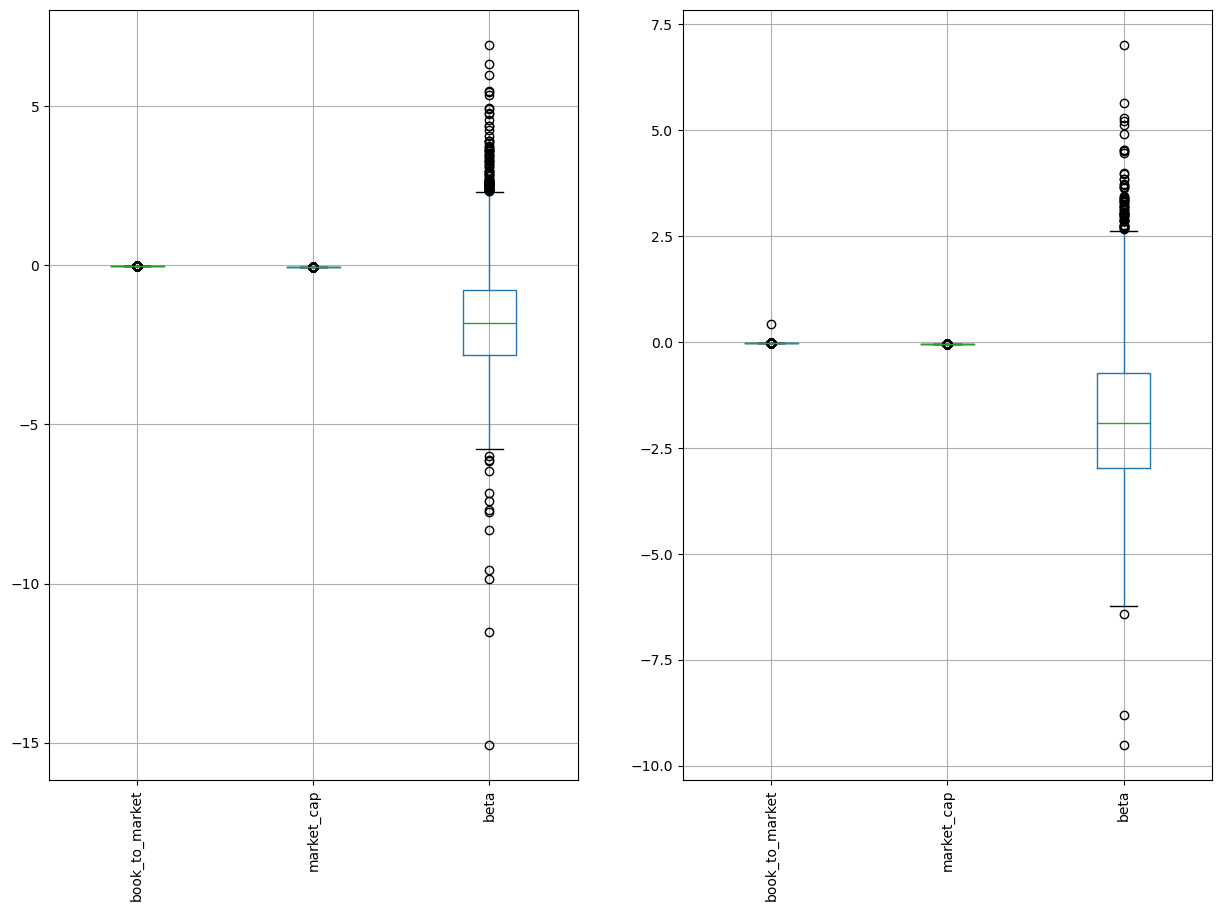

In [78]:
fig, axs = plt.subplots(1, 2, figsize = (15, 10))
pd.DataFrame(data = X_train_s, columns = X_train.columns).boxplot(figsize = (10, 10), rot = 90, ax = axs[0])
pd.DataFrame(data = X_test_s, columns = X_test.columns).boxplot(figsize = (10, 10), rot = 90, ax = axs[1])

In [99]:
lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)

y_test_pred = lin_reg.predict(X_test_s)
y_train_pred = lin_reg.predict(X_train_s)

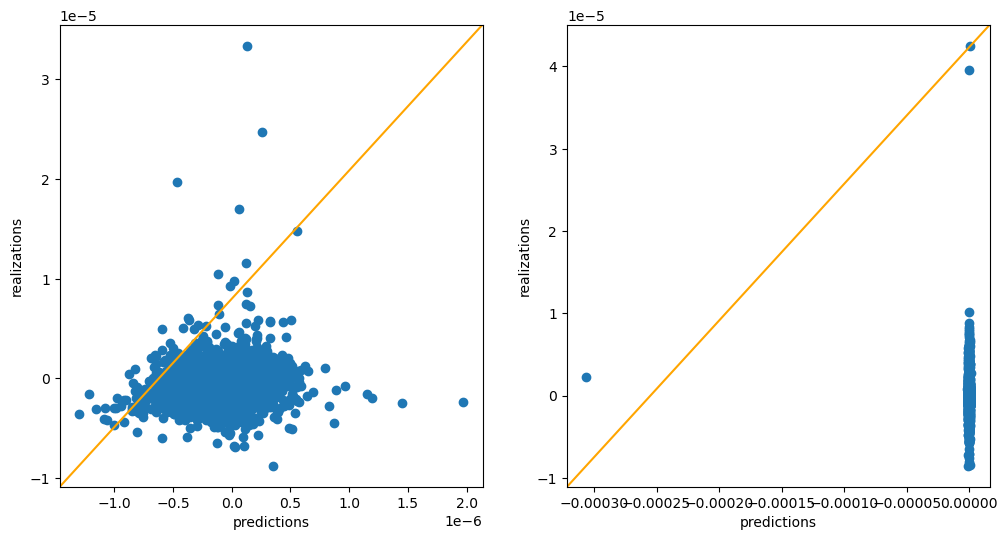

Training R2 score: 0.0250
Test R2 score: -7.2085


In [104]:
from sklearn.linear_model import LinearRegression
import matplotlib.pylab as plt
from sklearn.metrics import r2_score

lin_reg = LinearRegression()
lin_reg.fit(X_train_s, y_train)

y_train_pred = lin_reg.predict(X_train_s)
y_test_pred = lin_reg.predict(X_test_s) 

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].scatter(y_train_pred, y_train)
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, c = 'orange')
axs[0].set_xlabel('predictions')
axs[0].set_ylabel('realizations')

axs[1].scatter(y_test_pred, y_test)
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, c = 'orange')
axs[1].set_xlabel('predictions')
axs[1].set_ylabel('realizations')

plt.show()

print(f'Training R2 score: {r2_score(y_train, y_train_pred):.4f}')
print(f'Test R2 score: {r2_score(y_test, y_test_pred):.4f}')

In [81]:
lin_reg.coef_.flatten()

array([-6.95878414e-04, -4.53386959e+05, -1.48752060e-07])

In [82]:
X_train

,book_to_market,market_cap,beta
0,0.209056,4.860337e+09,0.678720
1,0.271499,6.261903e+07,2.186974
2,0.670605,1.916217e+09,1.292221
3,0.716247,1.277952e+10,0.944942
4,0.114538,1.498425e+09,1.782655
...,...,...,...
4958,0.297119,5.617804e+08,0.682003
4959,1.033569,4.502458e+07,1.771530
4960,2.310374,6.542758e+08,-0.030454
4961,0.609861,1.293700e+08,1.512720


<AxesSubplot: >

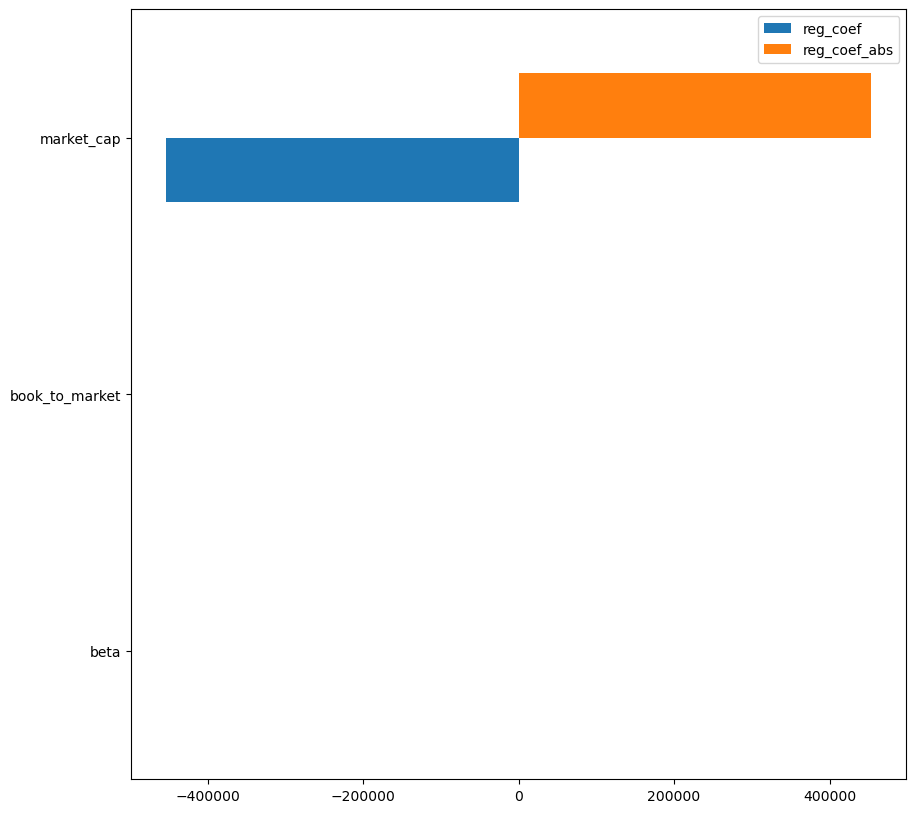

In [83]:
lin_reg_coef = pd.DataFrame(data = lin_reg.coef_.flatten(), index = X_train.columns, columns = ['reg_coef'])
lin_reg_coef.loc[:, 'reg_coef_abs'] = lin_reg_coef.reg_coef.abs()
lin_reg_coef.sort_values(by = 'reg_coef_abs', ascending = True, inplace = True)
lin_reg_coef.plot.barh(figsize = (10, 10))

In [84]:
X_train_alt = X_train_s.copy()
X_train_alt = sm.add_constant(X_train_alt, prepend=False)
y_train_alt = y_train.copy()

model = sm.OLS(y_train_alt, X_train_alt)
results = model.fit()
print(results.summary())

                            OLS Regression Results                            
Dep. Variable:                discr_r   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     42.32
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           5.33e-27
Time:                        12:26:56   Log-Likelihood:                 59265.
No. Observations:                4963   AIC:                        -1.185e+05
Df Residuals:                    4959   BIC:                        -1.185e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1            -0.0007      0.002     -0.338      0.7

In [85]:
columns = X_train.columns.to_list()
columns.append("const")

In [86]:
X_train_df = pd.DataFrame(X_train_alt, columns=[columns])
X_train_df

,book_to_market,market_cap,beta,const
0,-0.014771,-0.03997,-2.756145,1.0
1,-0.014771,-0.03997,1.596822,1.0
2,-0.014771,-0.03997,-0.985521,1.0
3,-0.014771,-0.03997,-1.987801,1.0
4,-0.014771,-0.03997,0.429918,1.0
...,...,...,...,...
4958,-0.014771,-0.03997,-2.746668,1.0
4959,-0.014771,-0.03997,0.397812,1.0
4960,-0.014771,-0.03997,-4.802888,1.0
4961,-0.014771,-0.03997,-0.349140,1.0


In [88]:
model_better = sm.OLS(y_train_alt, X_train_df)
res = model_better.fit()

print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                discr_r   R-squared:                       0.025
Model:                            OLS   Adj. R-squared:                  0.024
Method:                 Least Squares   F-statistic:                     42.32
Date:                Mon, 19 Dec 2022   Prob (F-statistic):           5.33e-27
Time:                        12:27:07   Log-Likelihood:                 59265.
No. Observations:                4963   AIC:                        -1.185e+05
Df Residuals:                    4959   BIC:                        -1.185e+05
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                     coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------
book_to_market    -0.0007      0.002     -0.

In [89]:
alt_lin_reg_coef = pd.DataFrame(res.params, columns=["reg_coef"])
alt_lin_reg_coef

,reg_coef
book_to_market,-6.952384e-04
market_cap,-4.533446e+05
beta,-1.486644e-07
const,-1.812035e+04


<AxesSubplot: >

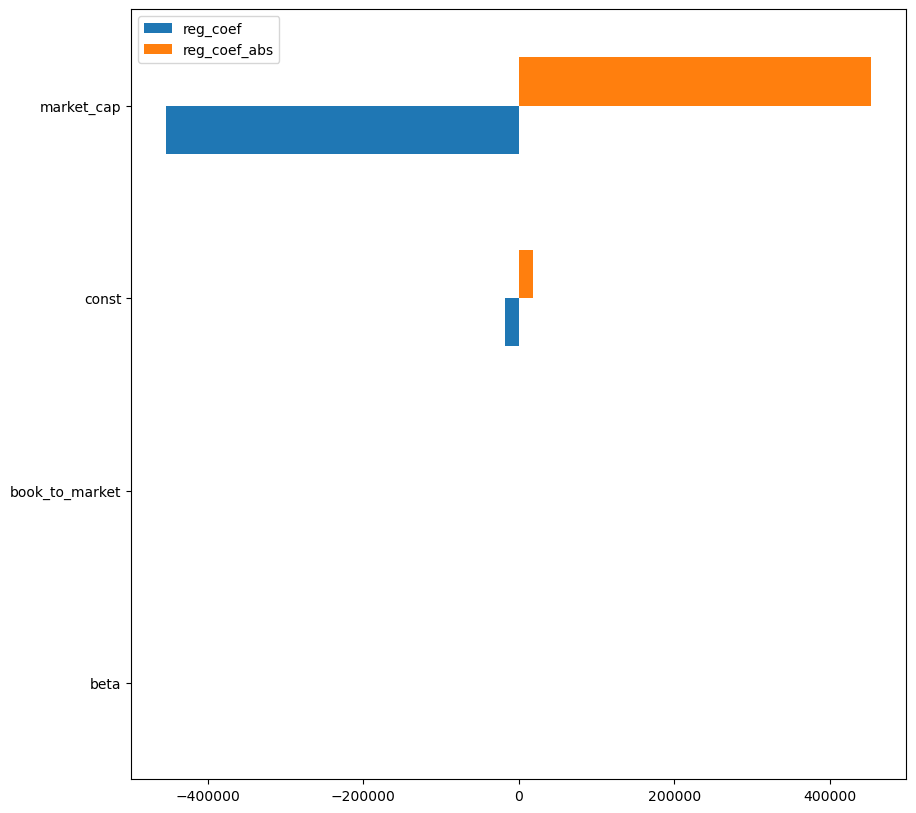

In [90]:
alt_lin_reg_coef.loc[:,"reg_coef_abs"] = alt_lin_reg_coef.abs()
alt_lin_reg_coef.sort_values(by="reg_coef_abs", ascending=True, inplace=True)
alt_lin_reg_coef.plot.barh(figsize=(10,10))

# 3.2 Mean-Absolute-Error

In [124]:
from sklearn.metrics import mean_absolute_error

In [127]:
print("Mean Absolute Error for training:", mean_absolute_error(y_train, y_train_pred))
print("Mean Absolute Error for testing:", mean_absolute_error(y_test, y_test_pred))

Mean Absolute Error for training: 1.0040396133848914e-06
Mean Absolute Error for testing: 1.027046035433779e-06


given the values from the mean absolute error of 1 for training and testing, predicting quality of our model can be seen as quite low.

# 4 Building a neural network

checking for activation functions

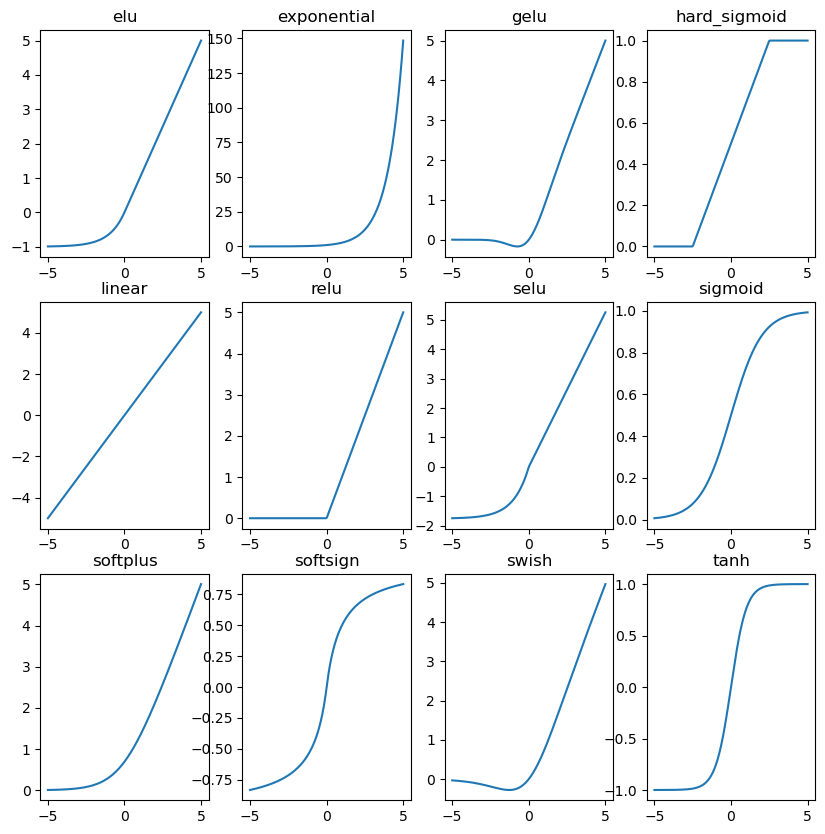

In [91]:
x = tf.convert_to_tensor(np.linspace(-5, 5, 200))

a_fun_names = ['elu', 'exponential', 'gelu', 'hard_sigmoid', 'linear', 'relu', 'selu', 'sigmoid', 'softplus', 'softsign', 'swish', 'tanh']

# number of subplots
Tot = len(a_fun_names)
Cols = 4

# Compute Rows required

Rows = Tot // Cols 

# If one additional row is necessary -> add one:

if Tot % Cols != 0:
    Rows += 1

# Create a Position index
Position = range(1,Tot + 1)

fig = plt.figure(1, figsize = (10, 10))
for k in range(Tot):
  # add every single subplot to the figure with a for loop
  a_fun = tf.keras.activations.deserialize(a_fun_names[k])
  ax = fig.add_subplot(Rows,Cols,Position[k])
  ax.plot(x.numpy(), a_fun(x).numpy())
  ax.set_title(a_fun_names[k])

In [92]:
output_fun = "linear"

Epoch 1/50
156/156 [==============================] - 1s 4ms/step - loss: 0.0059 - val_loss: 5.3165e-06
Epoch 2/50
156/156 [==============================] - 1s 5ms/step - loss: 5.1748e-06 - val_loss: 4.2412e-06
Epoch 3/50
156/156 [==============================] - 1s 3ms/step - loss: 3.5408e-06 - val_loss: 4.0187e-06
Epoch 4/50
156/156 [==============================] - 1s 4ms/step - loss: 2.9160e-06 - val_loss: 5.6070e-06
Epoch 5/50
156/156 [==============================] - 0s 3ms/step - loss: 2.6918e-06 - val_loss: 3.9502e-06
Epoch 6/50
156/156 [==============================] - 1s 3ms/step - loss: 1.9233e-06 - val_loss: 5.1188e-06
Epoch 7/50
156/156 [==============================] - 1s 3ms/step - loss: 1.7355e-06 - val_loss: 4.0978e-06
Epoch 8/50
156/156 [==============================] - 1s 6ms/step - loss: 1.2207e-06 - val_loss: 3.9030e-06
Epoch 9/50
156/156 [==============================] - 1s 7ms/step - loss: 9.2257e-07 - val_loss: 5.3164e-06
Epoch 10/50
156/156 [===========

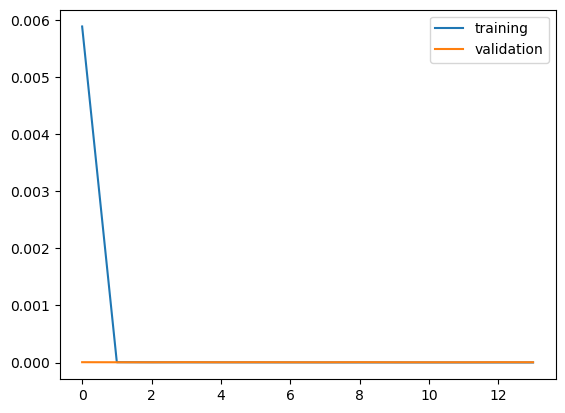

In [105]:
# define a neural network using the keras sequential api
my_model = tf.keras.Sequential([
    tf.keras.layers.InputLayer(input_shape = (X_train_s.shape[1])),
    tf.keras.layers.Dense(20, activation = 'tanh', name = 'hidden_layer'),
    tf.keras.layers.Dense(10, activation = 'tanh', name = 'hidden_layer2'),
    tf.keras.layers.Dense(1, activation = output_fun)
])

# alternative choices for the loss would be, e.g., the mean absolute error or the huber loss
optim_adam = tf.keras.optimizers.Adam(learning_rate = 0.01)
my_model.compile(loss = 'mean_squared_error', optimizer = optim_adam)
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = 3)
history = my_model.fit(X_train_s, y_train, epochs = 50, validation_data = ((X_test_s, y_test)), callbacks = [my_callback])

# we can visualize the evaluation of the loss during training
plt.plot(history.history['loss'], label = 'training')
plt.plot(history.history['val_loss'], label = 'validation')
plt.legend()
plt.show()

162/162 [==============================] - 0s 2ms/step


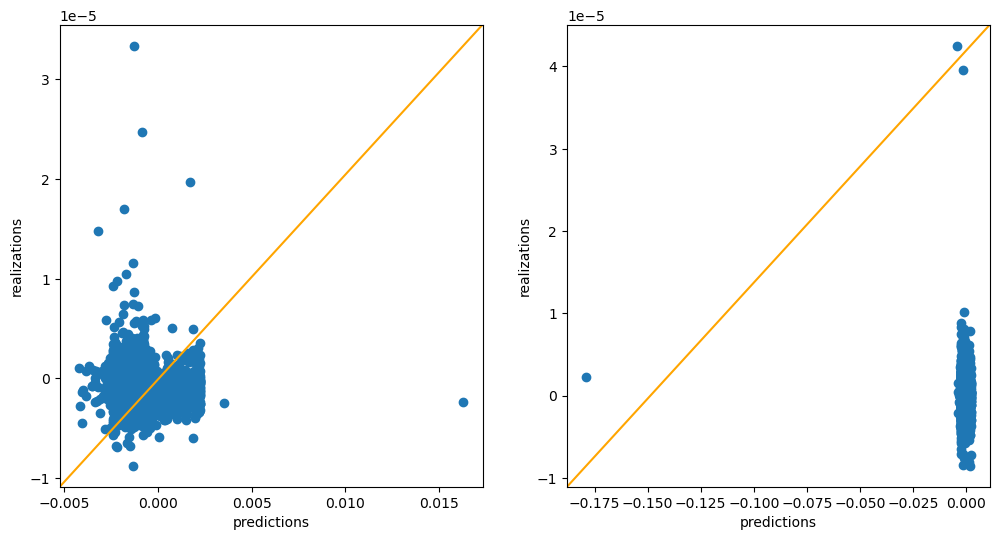

Training R2 score: -1072026.9337
Test R2 score: -3423864.2485


In [94]:
y_train_pred, y_test_pred = my_model.predict(X_train_s).flatten(), my_model.predict(X_test_s).flatten()

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].scatter(y_train_pred, y_train)
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, c = 'orange')
axs[0].set_xlabel('predictions')
axs[0].set_ylabel('realizations')

axs[1].scatter(y_test_pred, y_test)
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, c = 'orange')
axs[1].set_xlabel('predictions')
axs[1].set_ylabel('realizations')

plt.show()

print(f'Training R2 score: {r2_score(y_train, y_train_pred):.4f}')
print(f'Test R2 score: {r2_score(y_test, y_test_pred):.4f}')

r2 values of our neural network are too high to analyze. either wrong validation values were entered or the wrong activation function was selected 

# 5 Feature value Importance

In [109]:
import pandas as pd
import numpy as np
from scipy.stats import mode

# a function for feature analysis
def feature_analysis(X, nn, feature_names):
    # determine first and second partial derivatives
    with tf.GradientTape() as snd:
        snd.watch(X)
        with tf.GradientTape() as fst:
            fst.watch(X)
            # prediction with the neural network, i.e., f(X)
            pred = nn(X)
        # gradient
        g = fst.gradient(pred, X)
    # jacobian which outputs Hessian matrix
    h = snd.batch_jacobian(g, X)

    # first partial derivatives
    g_np = g.numpy()
    # average squard partial derivatives
    g_mag_sq = (g_np**2).mean(axis = 0)
    # square root of average squard partial derivatives
    g_mag = np.sqrt(g_mag_sq)
    # sign of average partial derivatives
    g_dir = np.sign(g_np.mean(axis = 0))

    # normalizing constant
    C_ = np.sum(g_mag)
    # normalized feature importance with sign
    fi = (g_mag * g_dir) / C_

    # get signs of each sample
    fi_signs = np.sign(g_np)
    # the mode is the sign which can be observed most often among all samples, the counts is how often this sign is observed
    fi_modes, fi_counts = mode(fi_signs)
    # dividing the count of the sign which is observed most often by the overall sample size gives us a frequency measure
    # which is closer to one, the higher the conformity of the sign
    fi_conformity = fi_counts / g_np.shape[0] #fi_modes * 

    # in analogy to the calculation above, we do the same thing with the second partial derivatives
    h_np = h.numpy()
    # get the square root of average squared direction of curvature and interactions
    h_mag_sq = (h_np**2).mean(axis = 0)
    h_mag = np.sqrt(h_mag_sq)

    # the the sign of average curvature and interactions
    h_dir = np.sign(h_np.mean(axis = 0))

    # normalize the values on the diagonal line to compare the degree of non-linearity
    C_nonlin = np.sum(h_mag.diagonal())
    nonlinearity = (h_dir.diagonal() * h_mag.diagonal()) / C_nonlin

    # normlize the interactions
    lti = np.tril_indices(h_mag.shape[0], k = -1)
    C_ia = np.sum(h_mag[lti])
    interactions = (h_mag[lti] * h_dir[lti]) / C_ia

    # bring curvature and interaction effects back to matrix format
    snd_degree_summary = np.diag(nonlinearity)
    a, b = lti
    inter_iter = iter(interactions)
    for i, j in zip(a, b):
        snd_degree_summary[i, j] = next(inter_iter)
        snd_degree_summary[j, i] = snd_degree_summary[i, j]

    # get the conformity of second order effects
    snd_signs = np.sign(h_np)
    snd_degree_modes, snd_degreee_counts = mode(snd_signs)
    snd_degree_conformity = snd_degreee_counts / h_np.shape[0] #snd_degree_modes * 

    # finally summarize feature importances and second order effects
    summary = pd.DataFrame(data = snd_degree_summary, index = feature_names, columns = feature_names)
    summary.loc[:, 'feature_importance'] = fi
    # as well as their conformity
    summary_conformity = pd.DataFrame(data = snd_degree_conformity.reshape(h_np.shape[1], h_np.shape[2]), index = feature_names, columns = feature_names)
    summary_conformity.loc[:, 'feature_importance'] = fi_conformity.flatten()

    return summary, summary_conformity

X_train_tensor = tf.Variable(X_train_s)
X_test_tensor = tf.Variable(X_test_s)
sum, sum_c = feature_analysis(X_train_tensor, my_model, X_train.columns)
sum_test, sum_c_test = feature_analysis(X_test_tensor, my_model, X_train.columns)

In [110]:
sum

,book_to_market,market_cap,beta,feature_importance
book_to_market,0.440205,0.132908,-0.360576,-0.608003
market_cap,0.132908,0.545682,0.506516,0.390829
beta,-0.360576,0.506516,0.014113,0.001168


<AxesSubplot: title={'center': 'feature importance'}>

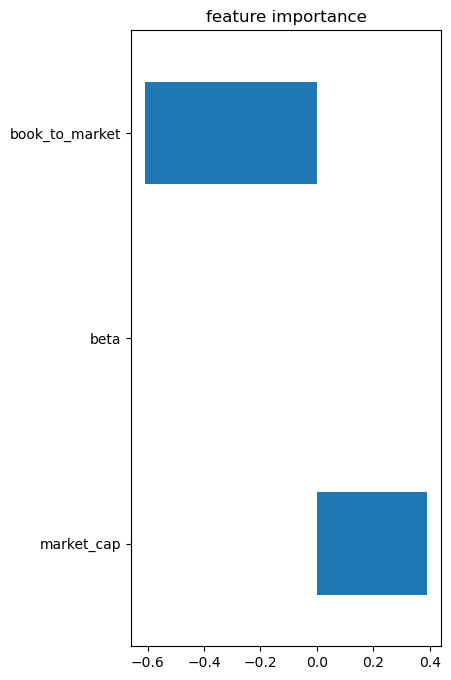

In [111]:
fig, axs = plt.subplots(figsize = (4, 8))
sum.feature_importance.sort_values(ascending = False).plot.barh(ax = axs, title = 'feature importance')

"book_to_market" can be seen as the most imoprtant feature variable!

### comparison of baseline and neural network feature importance:

both models show that "book to market" has the greatest impact on our target variable disc_r!

# 6 hyperparameter tuning with Optuna

In [1]:
!conda install -c conda-forge optuna

Solving environment: done

## Package Plan ##

  environment location: /Users/christophervoizard/opt/anaconda3

  added / updated specs:
    - optuna


The following packages will be downloaded:

    package                    |            build
    ---------------------------|-----------------
    alembic-1.9.0              |     pyhd8ed1ab_0         144 KB  conda-forge
    autopage-0.5.1             |     pyhd8ed1ab_0          26 KB  conda-forge
    ca-certificates-2022.12.7  |       h033912b_0         142 KB  conda-forge
    certifi-2022.12.7          |     pyhd8ed1ab_0         147 KB  conda-forge
    cliff-4.1.0                |     pyhd8ed1ab_0          52 KB  conda-forge
    cmaes-0.9.0                |     pyhd8ed1ab_0          21 KB  conda-forge
    cmd2-2.4.2                 |   py39h6e9494a_2         212 KB  conda-forge
    colorlog-6.7.0             |   py39h6e9494a_1          17 KB  conda-forge
    conda-22.11.1              |   py39h6e9494a_1         874 KB  conda-forge
  

In [8]:
!pip install optuna

In [9]:
import optuna
import tensorflow as tf
from sklearn.metrics import r2_score


# define an objective function whose output is optimized with respect to trial instances
def objective(trial):
  
  # check 1 up to 3 hidden layers 
  n_layers = trial.suggest_int('n_layers', 1, 3)

  # initialize an "empty" network
  my_model = tf.keras.Sequential()
  # we define a separate input layer which specifies the shape of feature variables
  my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

  # for each hidden layer
  for i in range(n_layers):
    # we search for an optimal amount of hidden neurons
    num_hidden = trial.suggest_int(f'n_units_l{i}', 4, 128, log=True)
    # and among the activation functions defined below
    a_fun = trial.suggest_categorical(f'a_fun_l{i}', ['tanh', 'sigmoid', 'relu'])  
    # add this hidden layer
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))

  # in the end add an output to predict the housing value
  my_model.add(tf.keras.layers.Dense(1, activation = output_fun))

  # we try among three different loss functions
  loss_fun = trial.suggest_categorical(f'loss_fun', ['mean_squared_error', 'mean_absolute_error', 'huber_loss'])
  # and two optimizers
  optim = trial.suggest_categorical(f'optimizer', ['Adam', 'RMSprop'])

  # compile the model
  my_model.compile(loss = loss_fun, optimizer = optim)
  
  # different callback parameters are available, we try the number of steps to wait for improvement of validation data
  # once the loss value for validation data does not improve for the number of patience steps the network optimization stops
  callback_patience = trial.suggest_int(f'callback_patience', 1, 5)
  my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = callback_patience)

  # if the loss for validation data always improves, the model is trained until the maximum number of epochs is reached
  n_epochs = trial.suggest_int(f'training_epochs', 10, 100)
  my_model.fit(X_train_s, y_train, epochs = n_epochs, validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

  # we aim to maximize validation/test data's R^2 which we output for the objective 
  y_test_pred = my_model.predict(X_test_s).flatten()
  r2_test = r2_score(y_test, y_test_pred)

  return r2_test

# create an optim study instance
study = optuna.create_study(direction='maximize')
# optimize hyperparameters for n_trials 
study.optimize(objective, n_trials=20)

ModuleNotFoundError: No module named 'optuna'

In [ ]:
import matplotlib.pylab as plt
from sklearn.metrics import r2_score

best_hparams = study.best_trial.params
print(best_hparams)
best_hparams_iterator = iter(study.best_trial.params)

n_layers = best_hparams[next(best_hparams_iterator)]

my_model = tf.keras.Sequential()
my_model.add(tf.keras.layers.InputLayer(input_shape = X_train.shape[1]))

for i in range(n_layers):
    num_hidden = best_hparams[next(best_hparams_iterator)]
    a_fun = best_hparams[next(best_hparams_iterator)]
    my_model.add(tf.keras.layers.Dense(num_hidden, activation = a_fun))

my_model.add(tf.keras.layers.Dense(1, activation = output_fun))

my_model.compile(loss = best_hparams['loss_fun'], optimizer = best_hparams['optimizer'])
my_callback = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = best_hparams['callback_patience'])
my_model.fit(X_train_s, y_train, epochs = best_hparams['training_epochs'], validation_data = (X_test_s, y_test), callbacks = [my_callback], verbose = 0)

y_train_pred, y_test_pred = my_model.predict(X_train_s).flatten(), my_model.predict(X_test_s).flatten()

fig, axs = plt.subplots(1, 2, figsize = (12, 6))

axs[0].scatter(y_train_pred, y_train)
axs[0].plot([0, 1], [0, 1], transform=axs[0].transAxes, c = 'orange')
axs[0].set_xlabel('predictions')
axs[0].set_ylabel('realizations')

axs[1].scatter(y_test_pred, y_test)
axs[1].plot([0, 1], [0, 1], transform=axs[1].transAxes, c = 'orange')
axs[1].set_xlabel('predictions')
axs[1].set_ylabel('realizations')

plt.show()

print(f'Training R2 score: {r2_score(y_train, y_train_pred):.4f}')
print(f'Test R2 score: {r2_score(y_test, y_test_pred):.4f}')

In [ ]:
import numpy as np

fig, axs = plt.subplots(1, 2, figsize = (8, 8), sharey = True)

X_train_tensor = tf.convert_to_tensor(X_train_s)
X_test_tensor = tf.convert_to_tensor(X_test_s)

with tf.GradientTape() as tape:
  tape.watch(X_train_tensor)
  y_train_pred = my_model(X_train_tensor)

grads = tape.gradient(y_train_pred, X_train_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[0])

with tf.GradientTape() as tape:
  tape.watch(X_test_tensor)
  y_test_pred = my_model(X_test_tensor)

grads = tape.gradient(y_test_pred, X_test_tensor).numpy()

feature_importance = np.sign(np.mean(grads, axis = 0)) * np.sqrt(np.mean(grads**2, axis = 0))
feature_importance_scaled = feature_importance / np.sum(np.abs(feature_importance))
feature_importance_df = pd.DataFrame(index = X_train.columns, data = feature_importance_scaled, columns = ['feature_importance'])
feature_importance_df.loc[:, 'feature_importance_abs'] = feature_importance_df.feature_importance.abs()
feature_importance_df.sort_values(by = 'feature_importance_abs', ascending = True, inplace = True)
feature_importance_df.plot.barh(ax = axs[1])


axs[0].legend(bbox_to_anchor=(0.95, 1.1))
axs[1].legend(bbox_to_anchor=(0.95, 1.1))